**AHMED KAMAL, DHRUV JOSHI**

Fall 2019

CS343: Neural Networks

Project 5: Word embeddings and SOMs

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 3) Implement a Self-Organizing Map (SOM) neural network

You will implement a SOM to visualize the word embeddings in 2D.

Implement the method stubs in `som.py`. I suggest working in the following order:
- constructor
- `compute_decayed_param`. Equation is $$p(t) = p\times exp \left (-t / \left ( \frac{T}{2} \right ) \right ) $$ Above, $p$ is the parameter (e.g. learning rate), $t$ is the current training iteration, $T$ is the total number of training iterations.
- `gaussian`.  Equation is: $$g(r, c) = \alpha(t)\times exp \left (- \left (|| M_{x,y} - (c,r) || \right ) / \left ( 2 \sigma^2 \right ) \right ) $$Above, $\alpha(t)$ is the current (decayed) learning rate, $M_{x,y}$ is the BMU neighborhood grid of (x,y) ordered pairs of SOM unit indices/positions, $(c,r)$ is the center of the Gaussian (BMU column, row position), and $\sigma$ is the current (decayed) standard deviation, $||\cdot||$ is the $L^2$ norm (over x,y values).
- `fit`
- `get_bmu`
- `get_nearest_wts`
- `update_wts`. SOM update rule is $$\vec{w_{rc}}(t) = \vec{w_{rc}}(t-1) + g(r_{bmu}, c_{bmu})\left ( \vec{\text{input_i}} - \vec{w_{rc}}(t-1)\right )$$Above, $w_{rc}$ is the SOM weight vector belonging to the unit positioned at row $r$ and column $c$, $t$ is iteration number, $g(r_{bmu}, c_{bmu})$ is the Gaussian neighborhood matrix centered on the BMU evaluated at the SOM $(row, col) = (r, c)$, $\text{input_i}$ is the data vector. NOTE: This weight update occurs to ALL SOM unit rows and columns $(r, c)$ at time t (due to the Gaussian neighborhood function).
- `error`
- `u_matrix`

As you implement, use the below code to test your implementation. This starts with simple toy data, then on the Iris dataset.

### a. Test implementation

In [2]:
import som

#### Test constructor

In [3]:
som_sz = 3
n_features = 2
max_iter = 10

np.random.seed(0)

test_som = som.SOM(som_sz, n_features, max_iter)
print(f'Your SOM initial weights (shape: {test_som.get_wts().shape}) are\n{test_som.get_wts()}')

Your SOM initial weights (shape: (3, 3, 2)) are
[[[ 0.975  0.221]
  [ 0.4    0.916]
  [ 0.886 -0.464]]

 [[ 0.988 -0.157]
  [-0.244  0.97 ]
  [ 0.099  0.995]]

 [[ 0.987  0.158]
  [ 0.799  0.601]
  [ 0.991 -0.136]]]


You should see:

    Your SOM initial weights (shape: (3, 3, 2)) are
    [[[ 0.975  0.221]
      [ 0.4    0.916]
      [ 0.886 -0.464]]

     [[ 0.988 -0.157]
      [-0.244  0.97 ]
      [ 0.099  0.995]]

     [[ 0.987  0.158]
      [ 0.799  0.601]
      [ 0.991 -0.136]]]

In [4]:
print(f'Shapes of your BMU neighborhood x {test_som.bmu_neighborhood_x.shape} and y {test_som.bmu_neighborhood_y.shape}.')
print('They should be (3, 3), (3, 3), and (3, 3)')
min_x, max_x = test_som.bmu_neighborhood_x.min(), test_som.bmu_neighborhood_x.max()
min_y, max_y = test_som.bmu_neighborhood_y.min(), test_som.bmu_neighborhood_y.max()
print(f'min/max of your x, y neighborhood grids are {min_x}/{max_x}, {min_y}/{max_y}')
print('They should be 0/2, 0/2')

Shapes of your BMU neighborhood x (3, 3) and y (3, 3).
They should be (3, 3), (3, 3), and (3, 3)
min/max of your x, y neighborhood grids are 0/2, 0/2
They should be 0/2, 0/2


#### Test learning rate decay function

In [5]:
vec = np.arange(10)
print(test_som.compute_decayed_param(vec, 1))
print(test_som.compute_decayed_param(20, vec[::-1]))

[1.    0.819 0.67  0.549 0.449 0.368 0.301 0.247 0.202 0.165]
[0.165 0.147 0.128 0.11  0.092 0.073 0.055 0.037 0.018 0.   ]


You should see:

    [1.    0.819 0.67  0.549 0.449 0.368 0.301 0.247 0.202 0.165]
    [0.165 0.147 0.128 0.11  0.092 0.073 0.055 0.037 0.018 0.   ]

#### Test Gaussian neighborhood function

##### Test 1

In [6]:
cent_xy = (1, 1)
sigma = 1.0
lr = 1.0
print(test_som.gaussian(cent_xy, sigma, lr))

[[0.368 0.607 0.368]
 [0.607 1.    0.607]
 [0.368 0.607 0.368]]


The Test 1 Gaussian neighborhood should look like:

    [[0.368 0.607 0.368]
     [0.607 1.    0.607]
     [0.368 0.607 0.368]]

##### Test 2

In [7]:
cent_xy = (0, 1)
print(test_som.gaussian(cent_xy, sigma, lr))

[[0.607 1.    0.607]
 [0.368 0.607 0.368]
 [0.082 0.135 0.082]]


The Test 2 Gaussian neighborhood should look like:

    [[0.607 1.    0.607]
     [0.368 0.607 0.368]
     [0.082 0.135 0.082]]

##### Test 3

In [8]:
cent_xy = (0, 1)
sigma = 0.5
print(test_som.gaussian(cent_xy, sigma, lr))

[[0.135 1.    0.135]
 [0.018 0.135 0.018]
 [0.    0.    0.   ]]


The Test 3 Gaussian neighborhood should look like:

    [[0.135 1.    0.135]
     [0.018 0.135 0.018]
     [0.    0.    0.   ]]

##### Test 4

In [9]:
cent_xy = (0, 1)
sigma = 0.5
lr = 0.5
print(test_som.gaussian(cent_xy, sigma, lr))

[[0.068 0.5   0.068]
 [0.009 0.068 0.009]
 [0.    0.    0.   ]]


The Test 4 Gaussian neighborhood should look like:

    [[0.068 0.5   0.068]
     [0.009 0.068 0.009]
     [0.    0.    0.   ]]

#### Test `get_nearest_wts` and  `get_bmu`

In [10]:
test_vec1 = np.array([0.916, 0.4])
test_vec1 = test_vec1[np.newaxis, ...]
test_som.get_nearest_wts(test_vec1)
print(f'The nearest wt vector to [0.916, 0.4] is {test_som.get_nearest_wts(test_vec1)[0]} and should be [0.975 0.221]')
test_vec2 = np.array([-1, -1])
test_vec2 = test_vec2[np.newaxis, ...]
print(f'The nearest wt vector to [-1, -1] is {test_som.get_nearest_wts(test_vec2)[0]} and should be [ 0.886 -0.464]')

The nearest wt vector to [0.916, 0.4] is [0.975 0.221] and should be [0.975 0.221]
The nearest wt vector to [-1, -1] is [ 0.886 -0.464] and should be [ 0.886 -0.464]


#### Test `update_wts`

In [11]:
np.random.seed(0)
som_sz = 3 # 5, 5
n_features = 2
max_iter = 10
t = 1

test_som = som.SOM(som_sz, n_features, max_iter)

input_vector = np.array([1, 1])
bmu_xy = (1, 1)

test_som.update_wts(t, input_vector, bmu_xy)
print(f'Weights after update are:\n{test_som.get_wts()}')

Weights after update are:
[[[ 0.979  0.347]
  [ 0.498  0.93 ]
  [ 0.904 -0.228]]

 [[ 0.99   0.031]
  [-0.04   0.975]
  [ 0.245  0.996]]

 [[ 0.989  0.294]
  [ 0.832  0.666]
  [ 0.992  0.047]]]


    Weights after update are:
    [[[ 0.979  0.347]
      [ 0.498  0.93 ]
      [ 0.904 -0.228]]

     [[ 0.99   0.031]
      [-0.04   0.975]
      [ 0.245  0.996]]

     [[ 0.989  0.294]
      [ 0.832  0.666]
      [ 0.992  0.047]]]

#### Test U-matrix

In [12]:
np.random.seed(0)
som_sz = 3 # 3, 3
n_features = 2
max_iter = 10

test_som = som.SOM(som_sz, n_features, max_iter)

In [13]:
print(f'Your U-matrix is:\n{test_som.u_matrix()}')

Your U-matrix is:
[[0.267 0.448 0.487]
 [0.43  1.    0.449]
 [0.224 0.387 0.38 ]]


Your output should be:
    
    Your U-matrix is:
    [[0.267 0.448 0.487]
     [0.43  1.    0.449]
     [0.224 0.387 0.38 ]]

### b. Test `fit` with Iris dataset

You will use the Iris dataset to test your `fit` function. Your goal is to qualitatively (roughly) reproduce the example image on Wikipedia (below).

- Preprocess the data in the pandas Dataframe below to produce `iris_x` (training data) and `iris_y` (classes).
    - For the training data, pull out all columns except for "species", then normalize each row by its Euclidean distance so that each vector sums to 1. Convert it from Dataframe to ndarray.
    - For the classes, convert to "species" column to an int-code (e.g. values take on 0, 1, 2). Convert from Dataframe to ndarray. 

In [14]:
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [15]:
# make iris_x
iris_x = iris.to_numpy()[:,:-1].astype(np.float)
mags = np.linalg.norm(iris_x,axis=1)
iris_x = iris_x/mags[:,np.newaxis]

In [16]:
# make iris_y
iris_labels = iris.to_numpy()[:,-1]
_, iris_y = np.unique(iris_labels,return_inverse=True)

#### Test Iris preprocessing

In [17]:
print(f'1st 4 rows of preprocessed iris:\n{iris_x[:4]}\n')
print(f'First 4 classes of iris:\n{iris_y[:4]}\n')
print(f'Last 4 classes of iris:\n{iris_y[-4:]}\n')

1st 4 rows of preprocessed iris:
[[0.804 0.552 0.221 0.032]
 [0.828 0.507 0.237 0.034]
 [0.805 0.548 0.223 0.034]
 [0.8   0.539 0.261 0.035]]

First 4 classes of iris:
[0 0 0 0]

Last 4 classes of iris:
[2 2 2 2]



Output should look like:

    1st 4 rows of preprocessed iris:
    [[0.804 0.552 0.221 0.032]
     [0.828 0.507 0.237 0.034]
     [0.805 0.548 0.223 0.034]
     [0.8   0.539 0.261 0.035]]

    First 4 classes of iris:
    [0 0 0 0]

    Last 4 classes of iris:
    [2 2 2 2]

##### Test `fit`, `u_matrix` after different number of training iterations

In [18]:
som_sz = 7
n_features = 4
max_iter = 1

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=0.2, init_sigma=10.0, verbose=False)
iris_u_map0 = iris_som.u_matrix()
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()
print(f'Quantization error after {max_iter} iterations: {iris_som.error(iris_x):.2f}')
print(f'Your initial u-matrix is (before any training):\n{iris_u_map0}')
print(f'Your u-matrix is (after 1 step):\n{iris_u_map}\n')

max_iter = 100
iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=0.2, init_sigma=10.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map2 = iris_som.u_matrix()
print(f'Quantization error after {max_iter} iterations: {iris_som.error(iris_x):.2f}')
print(f'Your u-matrix is (after 100 steps):\n{iris_u_map2}')

max_iter = 1000
iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=0.2, init_sigma=10.0, verbose=False)
iris_som.fit(iris_x.copy())
print(f'\nQuantization error after {max_iter} iterations: {iris_som.error(iris_x):.2f}')



100.00% complete

Quantization error after 1 iterations: 0.15
Your initial u-matrix is (before any training):
[[0.268 0.495 0.516 0.496 0.635 0.582 0.39 ]
 [0.538 0.956 0.931 0.794 0.776 0.771 0.464]
 [0.506 0.911 0.831 0.988 1.    0.751 0.502]
 [0.524 0.771 0.748 0.85  0.879 0.886 0.618]
 [0.405 0.745 0.755 0.714 0.782 0.907 0.586]
 [0.586 0.798 0.733 0.761 0.801 0.959 0.494]
 [0.311 0.508 0.44  0.409 0.48  0.548 0.417]]
Your u-matrix is (after 1 step):
[[0.267 0.494 0.516 0.498 0.643 0.595 0.4  ]
 [0.532 0.946 0.924 0.794 0.782 0.783 0.473]
 [0.497 0.894 0.819 0.98  1.    0.755 0.51 ]
 [0.511 0.753 0.732 0.837 0.872 0.885 0.621]
 [0.392 0.721 0.734 0.698 0.771 0.902 0.587]
 [0.564 0.771 0.71  0.741 0.787 0.951 0.495]
 [0.3   0.49  0.425 0.398 0.471 0.543 0.416]]

100.00% complete

Quantization error after 100 iterations: 0.07
Your u-matrix is (after 100 steps):
[[0.131 0.271 0.289 0.261 0.217 0.147 0.066]
 [0.348 0.549 0.529 0.479 0.386 0.285 0.137]
 [0.518 0.774 0.719 0.63  0.518 0.

You should see:

    Quantization error after 1 iterations: 0.14
    Your initial u-matrix is (before any training):
    [[0.268 0.495 0.516 0.496 0.635 0.582 0.39 ]
     [0.538 0.956 0.931 0.794 0.776 0.771 0.464]
     [0.506 0.911 0.831 0.988 1.    0.751 0.502]
     [0.524 0.771 0.748 0.85  0.879 0.886 0.618]
     [0.405 0.745 0.755 0.714 0.782 0.907 0.586]
     [0.586 0.798 0.733 0.761 0.801 0.959 0.494]
     [0.311 0.508 0.44  0.409 0.48  0.548 0.417]]
    Your u-matrix is (after 1 step):
    [[0.263 0.485 0.508 0.492 0.635 0.588 0.395]
     [0.528 0.937 0.917 0.787 0.776 0.778 0.472]
     [0.496 0.894 0.819 0.979 1.    0.757 0.51 ]
     [0.516 0.759 0.74  0.846 0.882 0.896 0.628]
     [0.402 0.739 0.752 0.715 0.79  0.923 0.6  ]
     [0.585 0.798 0.737 0.766 0.814 0.983 0.511]
     [0.312 0.511 0.445 0.415 0.491 0.565 0.433]]

    Quantization error after 100 iterations: 0.08
    Your u-matrix is (after 100 steps):
    [[0.049 0.21  0.419 0.606 0.648 0.583 0.298]
     [0.152 0.333 0.649 0.92  0.979 0.874 0.392]
     [0.215 0.488 0.71  0.96  1.    0.856 0.363]
     [0.435 0.719 0.9   0.98  0.966 0.798 0.38 ]
     [0.611 0.957 0.977 0.967 0.849 0.685 0.333]
     [0.668 0.999 0.957 0.853 0.722 0.552 0.241]
     [0.323 0.475 0.478 0.446 0.382 0.296 0.135]]

    Quantization error after 1000 iterations: 0.03

##### Have SOM learn structure of Iris data

If all goes well, your u-map superimposed with the most active units for each training sample should (qualitatively) look like the lower-right image on Wikipedia: https://en.wikipedia.org/wiki/Self-organizing_map#/media/File:SOM_of_Fishers_Iris_flower_data_set.JPG

100.00% complete



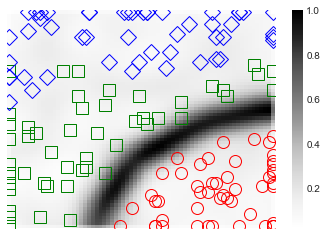

In [19]:
som_sz = 70
n_features = 4
max_iter = 10000

np.random.seed(0)

iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=3, init_sigma=51.0, verbose=False)
iris_som.fit(iris_x.copy())
iris_u_map = iris_som.u_matrix()

plt.pcolor(iris_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])

markers = ['o','s','D']
colors = ['r','g','b']

for i in range(len(iris_x)):
    bmu_pos = iris_som.get_bmu(iris_x[i])
    plt.plot(bmu_pos[0] + 0.5,
             bmu_pos[1] + 0.5,
             markers[iris_y[i]],
             markeredgecolor=colors[iris_y[i]],
             markersize=12,
             markerfacecolor='None')
plt.show()

- **Question 3**: What do the different shaped/colored plot markers represent in the visualization?

**Answer 3**: Each colored/shaped plot marker is a class from the iris dataset. Red circles are setosas, green squares are versicolors, and blue diamonds are virginicas.


- **Question 4**: Explain what the above visualizaion is showing us. Why does the plot look different than Iris scatterplots like you're used to seeing?

**Answer 4**: The above visualization shows us how closely related or similar any two examples in the iris dataset are. This, almost obviously, results in examples of the same class being clustered together. However, we have a black arc at the back of the plot. This comes from the u-matrix of our SOM - it tells us the distance between nodes in that area. The black ring here tells us that the red circles are very far from the green squares. The lack of any such strong boundary between green squares and blue diamonds tells us they are more closely related.


- **Question 5**: How do we make use of the Iris classes (species) in the above visualization? Does training depend on them?

**Answer 5**: The above classes are used to label the Best-Matching-Units for every training example in the dataset. Training does not depend on them. This makes the fact that the same class is clustered together very impressive, and is at the crux of SOMs being a method of unsupervised learning.

100.00% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete



/Users/dhruv/Documents/All Documents Backup/School/2019 Fall/CS343/Project5/Final/som.py:177: RuntimeWarning: overflow encountered in square
  distances = np.sqrt(np.sum(np.square(self.wts-input_vector[np.newaxis,np.newaxis,...]),axis=2))
/Users/dhruv/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100.00% complete



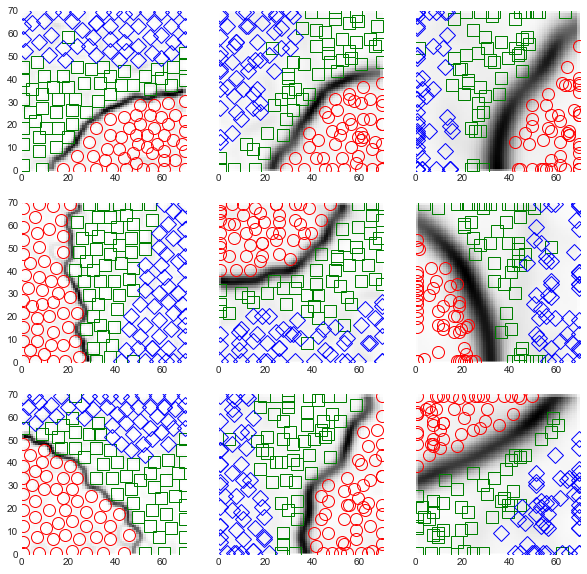

In [20]:
som_sz = 70
n_features = 4
max_iter = 10000

np.random.seed(0)

f, (a1,a2,a3) = plt.subplots(3, 3, figsize=(10,10), sharey=True)
axes = [a1[0],a1[1],a1[2],a2[0],a2[1],a2[2],a3[0],a3[1],a3[2]]

init_lrs = [1,1,1,3,3,3,4,4,4]
init_sigmas = [10,30,60,10,30,60,10,30,60]

for j in range(9):
    iris_som = som.SOM(som_sz, n_features, max_iter, init_lr=init_lrs[j], init_sigma=init_sigmas[j], verbose=False)
    iris_som.fit(iris_x.copy())
    iris_u_map = iris_som.u_matrix()

    axes[j].pcolor(iris_u_map.T)

    markers = ['o','s','D']
    colors = ['r','g','b']

    for i in range(len(iris_x)):
        bmu_pos = iris_som.get_bmu(iris_x[i])
        axes[j].plot(bmu_pos[0] + 0.5,
                 bmu_pos[1] + 0.5,
                 markers[iris_y[i]],
                 markeredgecolor=colors[iris_y[i]],
                 markersize=12,
                 markerfacecolor='None')
        
plt.show()

15.73% complete

28.95% complete

39.85% complete

51.63% complete

77.45% complete

90.48% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete

100.00% complete



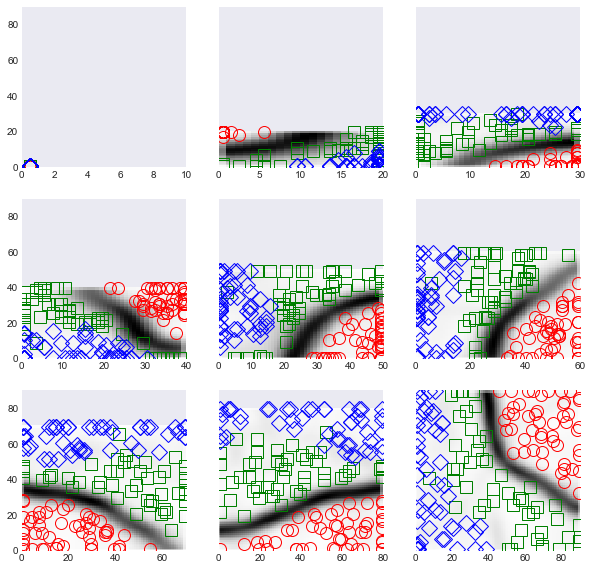

In [28]:
som_sz = 70
n_features = 4
max_iter = 10000

np.random.seed(0)

f, (a1,a2,a3) = plt.subplots(3, 3, figsize=(10,10), sharey=True)
axes = [a1[0],a1[1],a1[2],a2[0],a2[1],a2[2],a3[0],a3[1],a3[2]]

som_sz = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for j in range(9):
    iris_som = som.SOM(som_sz[j], n_features, max_iter, init_lr=3, init_sigma=51, verbose=False)
    iris_som.fit(iris_x.copy())
    iris_u_map = iris_som.u_matrix()

    axes[j].pcolor(iris_u_map.T)

    markers = ['o','s','D']
    colors = ['r','g','b']

    for i in range(len(iris_x)):
        bmu_pos = iris_som.get_bmu(iris_x[i])
        axes[j].plot(bmu_pos[0] + 0.5,
                 bmu_pos[1] + 0.5,
                 markers[iris_y[i]],
                 markeredgecolor=colors[iris_y[i]],
                 markersize=12,
                 markerfacecolor='None')
        
plt.show()

- **Question 6**: Copy the plot with default hyperparameters into a separate cell (or save it in your project folder). Then play around with the hyperparameters. Report on what how each affects the map. Does it matter that the clusters may jump around? Explain why.

**Answer 6**: Varying the hyper parameters, we see that increasing the sigma results in larger black lines and more sporadically spread data (more overplaps). On the other hand we see that changing the learning rate doesnt result in a noticable change in the results. Although changes in the hyperparmeters make the clusters jump around, this does not affect the results as long as the clusters form.


- **Question 7**: How stable are the hyperparameters in generating distinct clusters? Back up your observations with some numbers (i.e. parameter ranges ranges, things you experimented with).

**Answer 7**: As we see, increasing the initial sigma value from 10 to 60, the results are more sporadically spread, however, this too is within their general clusters. However with lower sigma values, we see more evenly spread clusters. 


- **Question 8**: See what happens when you shrink the map size. What's the consequence for classifying new data with the smaller map size?

**Answer 8**: The consequences of a smaller map is not being able to represent all the different cases for the same classes easily and thus not being able to account for different conditions for the class. Thus, classifying new data will smaller map sizes will often just be mapped onto the same node, not allowing the model to be used for predictions.

### c. Visualize word embedding vectors

The below parameters should work out-of-the-box for creating a "word cloud" of the IMDb word embedding vectors. Tweak as needed.

In [21]:
word_vectors = np.load('results/imdb_word_vectors.npy')
word_strings = np.load('results/imdb_word_strings.npy')
print(f'Loaded {len(word_vectors)} word embedding vectors and {len(word_strings)} words.')

Loaded 1016 word embedding vectors and 1016 words.


#### Train the SOM on word vectors and look at the U-matrix

- Create a SOM object, fit it to the word vectors, get the U-matrix (`word_u_map`), use the below code to plot it.

Training should take around 1 minutes or less with the following default parameters:

- size of SOM (in either x or y): 100
- max iterations: 100,000
- learning rate: 2
- initial Gaussian neighborhood standard deviation: 40

The U-matrix should have structure to it (not look like salt-and-pepper pixel noise or be completely black/white/gray)

100.00% complete



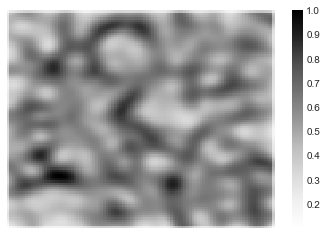

In [22]:
# Make SOM here, train it, etc

np.random.seed(0)
word_som = som.SOM(100, 10, 100000, init_lr=2, init_sigma=40.0, verbose=False)
word_som.fit(word_vectors.copy())
word_u_map = word_som.u_matrix()

plt.pcolor(word_u_map.T)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

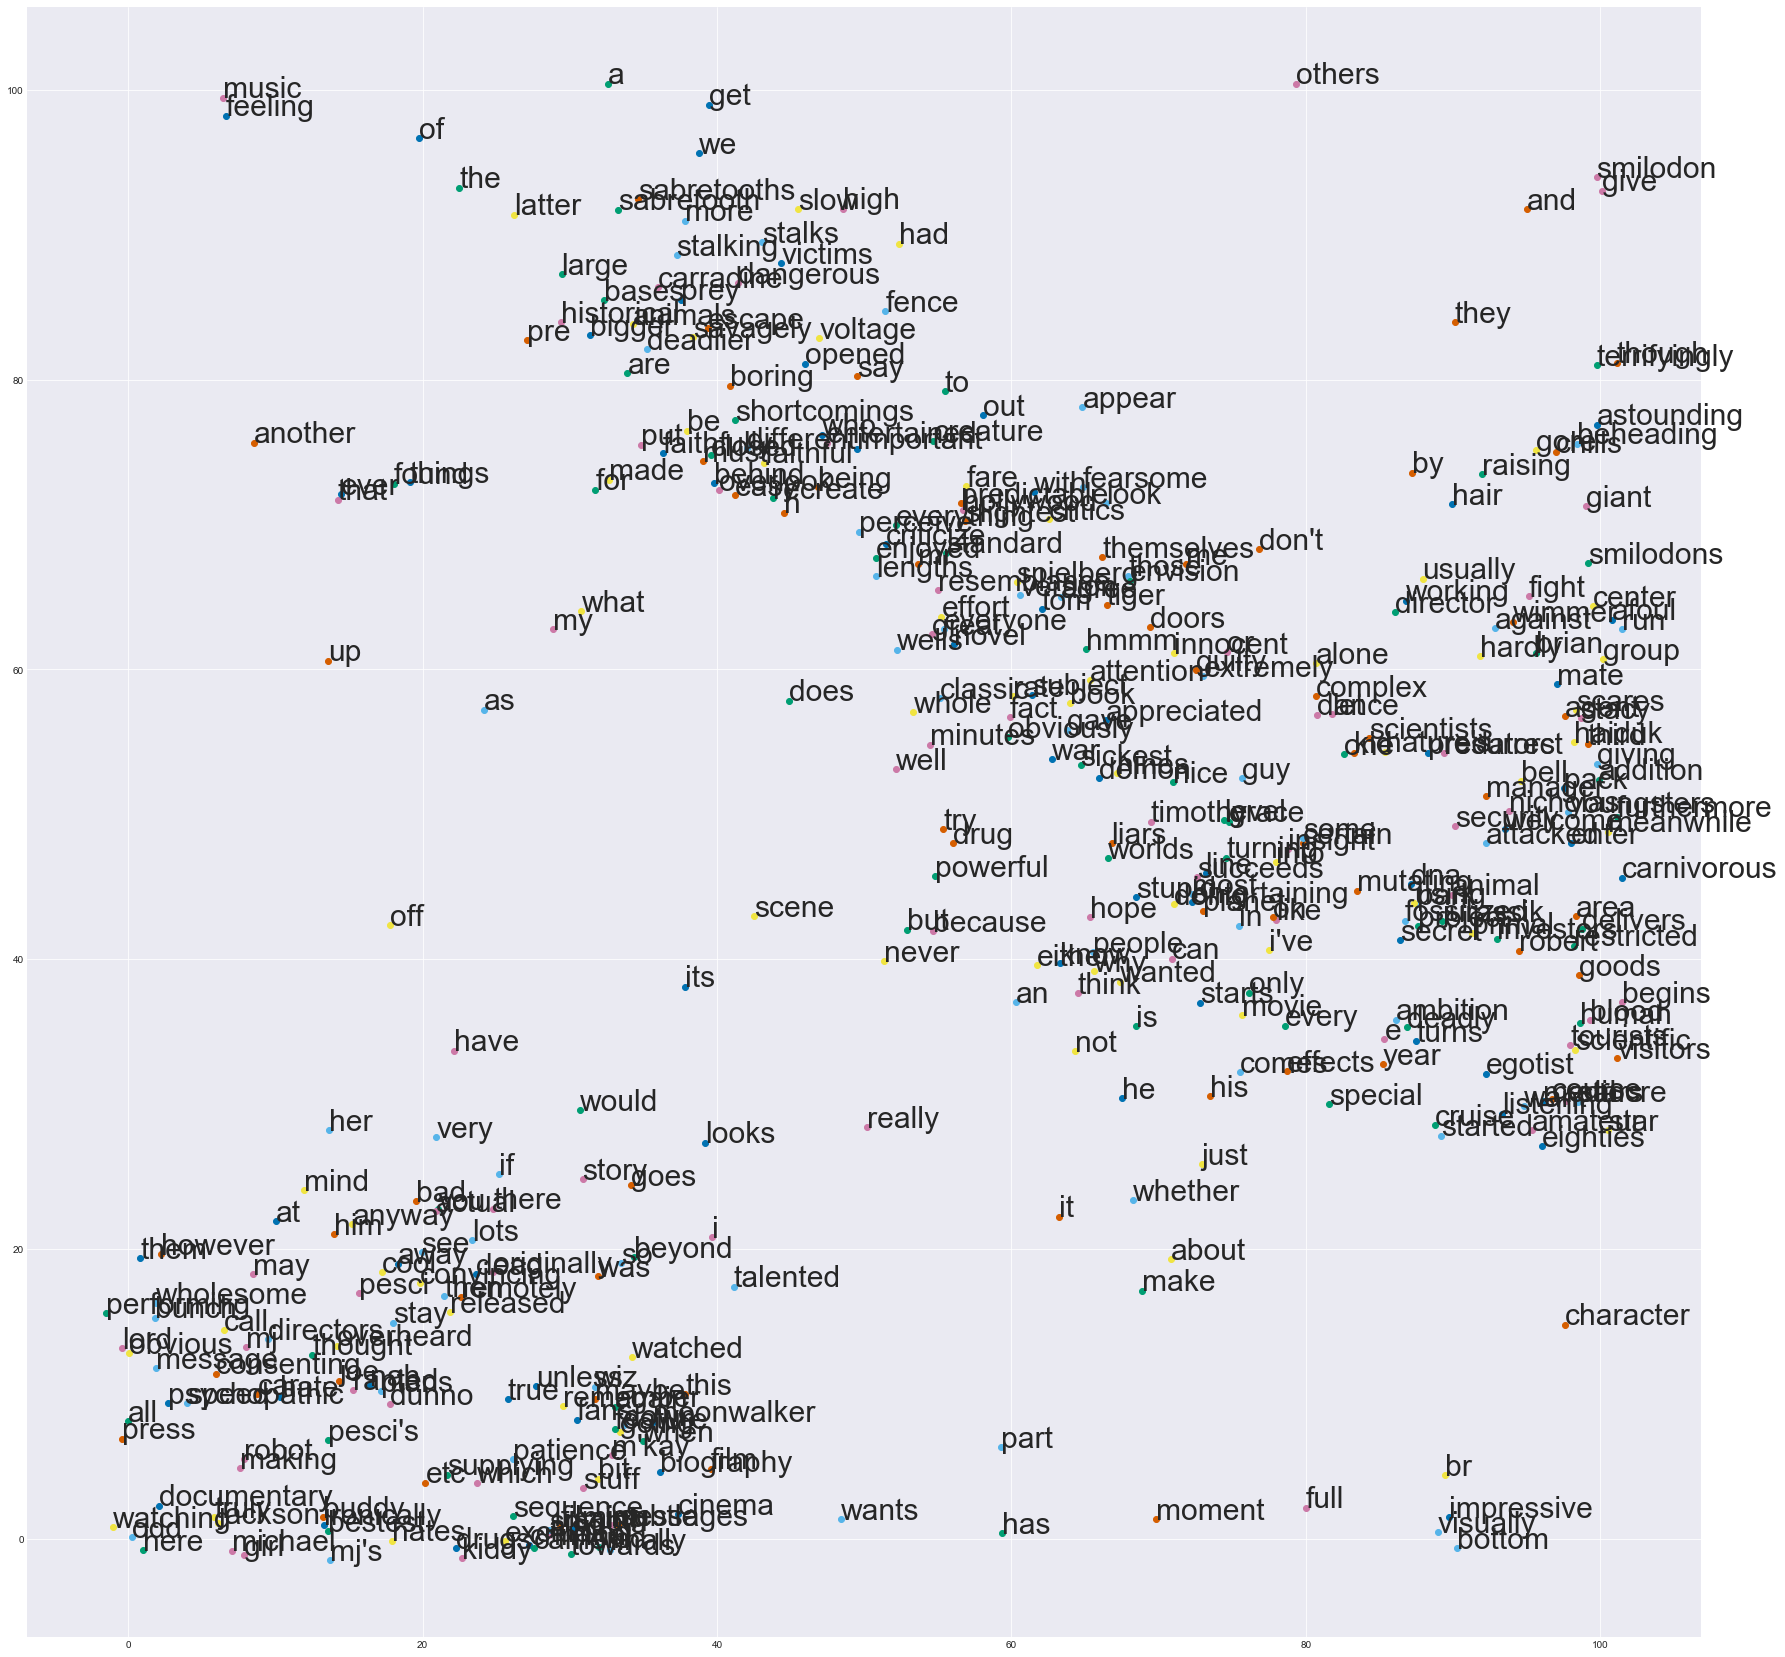

In [23]:
num_words_to_visualize = 400
jitter = 2

fig, ax = plt.subplots(figsize=(30, 30))
for i in range(len(word_vectors[:num_words_to_visualize])):
    bmu_pos = word_som.get_bmu(word_vectors[i])
    # jitter the placement of words so that they are less likely to plot ontop of each other
    x = bmu_pos[0] + 0.5 + jitter*(2*np.random.random()-1)
    y = bmu_pos[1] + 0.5 + jitter*(2*np.random.random()-1)
    ax.scatter(x, y)
    ax.annotate(str(word_strings[i]), (x, y), fontsize=30)
plt.show()

**Question 9:** What are your favorite word clusters? Are there any word groupings that surprised you (but make sense post-hoc)?

**Answer 9:** Some of the most amusing word clusters are Micheal-Jackson, He-His, Music-Feeling, Try-Drug, Hair-Raising, and finally, Visually-Impressive-Botttom. Clusters such as hair-raising don't make immediate sense, since the two words are not very related, but given the way we trained our word embeddings, the phrase hair-raising might have introduced a bias (sicne it can be used to describe how a movie made one feel).


**Question 10:** How does the number of iterations affect the apparent quality of the word vector mapping? For example, does the visualization make sense when you decrease/increase the iteration count? How stable does it seem? Does it break down at any point?

**Answer 10:** The default 100,000 iterations definitely yeild some structure in the SOM, especially given that our word vectors are relativley weak. Dropping down to 1000 iterations as opposed to 100000 still gave some structure to the SOM. Dropping down to 10 iterations actually yeilded the tightest clusters, but that also means that the SOM is untrained and really just dumps every word into the same box. Using 200,000 iterations, we don't get much more topographical organization than we did with 100,000 iterations.

## Extensions

### BERT Model Embedding

For this project I implemented a bert model embedder that would create a SOM map using Googles pretrained BERT model. The results can be seen in the Extension.ipynb